## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [122]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

nltk.download('punkt')
nltk.download('stopwords')
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

[nltk_data] Downloading package punkt to C:\Users\Rakesh
[nltk_data]     Panigrahy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rakesh
[nltk_data]     Panigrahy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [59]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json', 'r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
f.close()
df=pd.json_normalize(data)

## Data preparation

In [60]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [61]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [62]:
#Assign new column names
df.rename(columns={'_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'}, inplace=True)

In [63]:
#Assign nan in place of blanks in the complaints column
df.loc[df['complaint'] == '', 'complaint'] = np.nan

In [64]:
#Remove all rows where complaints column is nan
df = df[df['complaint'].notna()]
df.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [65]:
df['complaint'].values[0]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [116]:
# Write your function here to clean the text and remove all the unnecessary elements.
stops_remove_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, stopwords.words("english"))))

#Write your function to extract the POS tags 
def pos_tag(text):
  # write your code here
    return ' '.join(tok.text for tok in load_model(text) if tok.pos_ == 'NOUN')

def text_preprocess(x):
    #POS Tagging and remove all others except NOUN words
    x = pos_tag(x)
    
    #Remove XXXX
    pattern = "X{2,}\d*"
    x = re.sub(pattern, "", x)
    
    #Remove Special Characters
    x ="".join(ch for ch in x if ch.isalpha() or ch == ' ')
    
    #Lowercase
    x = x.lower()
    
#     # tokenize into words
#     words = word_tokenize(x)

#     # remove stop words
#     words = [word for word in words if word not in stopwords.words("english")]

#     # join words to make sentence
#     x = " ".join(words)k
    x = stops_remove_regex.sub("", x)
    
    #Remove Extra Spaces
    x = " ".join(x.split())
    
    return x

In [117]:
#Write your function to Lemmatize the texts
def lemmatize(x):
    doc = load_model(x)
    x = " ".join([token.lemma_ for token in doc])
    return x

In [118]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
print('Text Preprocessing Start')
df_clean['complaint'] = df['complaint'].apply(text_preprocess)

print('Text Lemmatizitaion Start')
df_clean['complaint_lemmatized'] = df_clean['complaint'].apply(lemmatize)

Text Preprocessing Start
Text Lemmatizitaion Start


In [119]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemmatized
1,morning name stop cardmember services debt ver...,morning name stop cardmember service debt veri...
2,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,application identity consent services credit i...,application identity consent service credit id...
11,ticket offer ticket rewards card information o...,ticket offer ticket reward card information of...
14,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...
78303,customer decade solicitations credit cards bon...,customer decade solicitation credit card bonus...
78309,provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...
78310,pay risk consumers bank app years banking merc...,pay risk consumers bank app year banking merch...
78311,credit yrs credit cards problems balance trans...,credit yrs credit card problem balance transfe...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




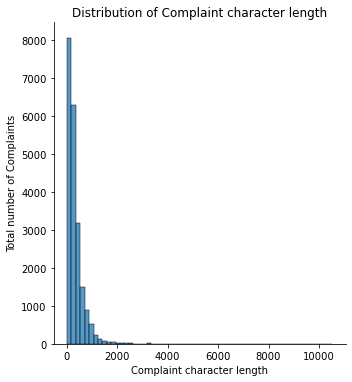

In [129]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_lemmatized']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [131]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# word_text = ' '.join(df_clean['complaint_lemmatized'].values)
# wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', max_words=40).generate(word_text)

# plt.figure(figsize=(15,10))
# plt.clf()
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()


# stopwords = set(STOPWORDS)
# wordcloud = WordCloud(max_font_size=60, max_words=40, 
#                       background_color="white", random_state=100, 
#                       stopwords=stopwords).generate(str(df_clean['complaint_lemmatized']))
# plt.figure(figsize=[12,12])
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [ ]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [132]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [145]:
#Print the top 10 words in the unigram frequency
top_10words = get_top_ngrams(df_clean['complaint_lemmatized'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_10words, columns=['unigram', 'count'])
df_unigram.head(10)

,unigram,count
0,account,46604
1,credit,29695
2,card,27542
3,payment,20833
4,bank,17680
5,time,14534
6,day,13174
7,check,12673
8,charge,12088
9,money,11931


In [142]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_10words = get_top_ngrams(df_clean['complaint_lemmatized'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_10words, columns=['bigram', 'count'])

In [144]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,11369
1,credit report,3712
2,account account,3460
3,check account,2863
4,customer service,2637
5,bank account,2387
6,debit card,1988
7,payment payment,1860
8,card account,1750
9,account credit,1742


In [146]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_10words = get_top_ngrams(df_clean['complaint_lemmatized'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_10words, columns=['bigram', 'count'])

In [148]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,bigram,count
0,credit card account,1029
1,credit card company,912
2,credit card credit,643
3,card credit card,550
4,account credit card,532
5,inquiry credit report,531
6,charge credit card,467
7,credit report credit,357
8,credit card card,351
9,account account account,346


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [149]:
#Write your code here to initialise the TfidfVectorizer 

vect = TfidfVectorizer(stop_words='english')

C:\Users\Rakesh Panigrahy\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,aaa,aacount,aaoa,abandon,abandonment,abatement,abbreviation,abd,aberration,...,zeal,zero,zeros,zilch,zip,zipcode,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [150]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean['complaint_lemmatized'].values)

pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

C:\Users\Rakesh Panigrahy\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,aaa,aacount,aaoa,abandon,abandonment,abatement,abbreviation,abd,aberration,...,zeal,zero,zeros,zilch,zip,zipcode,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [151]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [169]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [170]:
nmf_model.fit(X)
len(vect.get_feature_names())

C:\Users\Rakesh Panigrahy\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



11529

In [172]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

C:\Users\Rakesh Panigrahy\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,deposit,day,branch,fee,business,number,transaction,chase,customer,transfer
Topic 2,card,credit,balance,account,fee,limit,year,chase,purchase,month,score,point,offer,customer,time
Topic 3,payment,loan,mortgage,month,time,year,home,modification,balance,fee,rate,statement,day,property,date
Topic 4,report,credit,inquiry,information,company,debt,score,account,letter,bureaus,identity,application,theft,file,agency
Topic 5,charge,transaction,dispute,claim,merchant,fraud,company,letter,day,purchase,email,information,service,phone,time


In [174]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# Create a topic mapping

topic_mapping = {
    'Topic 1': 'Bank account services',
    'Topic 2': 'Credit card / Prepaid card',
    'Topic 3': 'Mortgages/loans',
    'Topic 5': 'Mortgages/loans',
    'Topic 4': 'Others',
    'Topic 5': 'Theft/Dispute reporting'
}


In [189]:
#Assign the best topic to each of the cmplaints in Topic Column

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

df_clean['Topic'] = W['max_topic']

In [190]:
df_clean.head()

,complaint,complaint_lemmatized,Topic
1,morning name stop cardmember services debt ver...,morning name stop cardmember service debt veri...,Credit card / Prepaid card
2,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Others
10,application identity consent services credit i...,application identity consent service credit id...,Bank account services
11,ticket offer ticket rewards card information o...,ticket offer ticket reward card information of...,Others
14,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Credit card / Prepaid card


In [191]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint,complaint_lemmatized,Topic
52,roommate debit card drivers license money acco...,roommate debit card driver license money accou...,Bank account services
10,application identity consent services credit i...,application identity consent service credit id...,Bank account services
45,purchase amount transaction disputes case bank...,purchase amount transaction dispute case bank ...,Bank account services
15,inquiry,inquiry,Bank account services
17,notice account debit card branch customer serv...,notice account debit card branch customer serv...,Bank account services
1,morning name stop cardmember services debt ver...,morning name stop cardmember service debt veri...,Credit card / Prepaid card
26,times attempt inquiry creditor inquiry report ...,time attempt inquiry creditor inquiry report a...,Credit card / Prepaid card
21,payment retailer pay website scam website conf...,payment retailer pay website scam website conf...,Credit card / Prepaid card
27,account bank code bonus terms account deposit ...,account bank code bonus term account deposit b...,Credit card / Prepaid card
14,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Credit card / Prepaid card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



